# Word2Vec(Skip-Gram)
### (Based on Distributed Representations of Words and Phrases)

## Step 1: Load and Tokenize WikiText-2
1. Load WikiText-2 using Hugging Face's datasets library.
2. Preprocess the text by tokenizing it into words.
3. Build the vocabulary and map words to indices.


In [1]:
from datasets import load_dataset
from collections import Counter
import torch
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Step 1.1: Load the WikiText-2 dataset
def load_wikitext2():
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")  # Use the training split
    return dataset["text"]

text_data = load_wikitext2()
text_data[:5]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

In [3]:
# Step 1.2: Tokenize the text
def tokenize_text(text):
    tokenized_corpus = [sentence.split() for sentence in text if sentence.strip()]  # Split by words, remove empty lines
    return tokenized_corpus

tokenized_corpus = tokenize_text(text_data)
tokenized_corpus[0]

['=', 'Valkyria', 'Chronicles', 'III', '=']

In [4]:
import nltk
from nltk.corpus import stopwords
import string
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to clean the tokenized text
def clean_tokenized_text(tokenized_corpus):
    stop_words = set(stopwords.words('english'))  # Load English stopwords
    cleaned_corpus = []
    
    for sentence in tokenized_corpus:
        # Remove punctuation, numbers, and symbols; convert to lowercase
        cleaned_sentence = [
            word.lower()
            for word in sentence
            if word.lower() not in stop_words  # Remove stopwords
            and not re.search(r'\d', word)  # Remove words containing digits
            and word.isalpha()  # Keep only alphabetic words
        ]
        cleaned_corpus.append(cleaned_sentence)
    
    return cleaned_corpus

tokenized_corpus = clean_tokenized_text(tokenized_corpus)

# View the first cleaned sentence
print(tokenized_corpus[0])

[nltk_data] Downloading package stopwords to /home/deep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['valkyria', 'chronicles', 'iii']


In [5]:
# Step 1.3: Build vocabulary with subsampling of frequent words
def build_vocab_with_subsampling(tokenized_corpus, threshold=1e-5):
    # Count the frequency of words
    word_counts = Counter(word for sentence in tokenized_corpus for word in sentence)
    total_word_count = sum(word_counts.values())

    # Compute word frequencies
    word_frequencies = {word: count / total_word_count for word, count in word_counts.items()}
    
    # Subsampling: Compute the probability of keeping each word
    subsample_probabilities = {
        word: min(1, (threshold / freq)**0.5)
        for word, freq in word_frequencies.items()
    }
    
    # Apply subsampling to the tokenized corpus
    subsampled_corpus = []
    for sentence in tokenized_corpus:
        subsampled_sentence = [
            word for word in sentence if random.random() < subsample_probabilities[word]
        ]
        if subsampled_sentence:  # Keep only non-empty sentences
            subsampled_corpus.append(subsampled_sentence)
    
    # Build the vocabulary from the subsampled corpus
    word_counts = Counter(word for sentence in subsampled_corpus for word in sentence)
    vocabulary = {word: idx for idx, (word, _) in enumerate(word_counts.items())}
    
    return vocabulary, word_counts, subsampled_corpus

vocabulary, word_counts, subsampled_corpus = build_vocab_with_subsampling(tokenized_corpus)

# Check vocabulary size and most common words after subsampling
len(vocabulary), word_counts.most_common(10)

(62413,
 [('one', 219),
  ('also', 219),
  ('first', 208),
  ('new', 182),
  ('two', 180),
  ('time', 148),
  ('later', 142),
  ('would', 141),
  ('city', 141),
  ('season', 138)])

# 2. Skip-gram
## Step 1: Generate (center word, context word) pairs
For the Skip-Gram model:
- Select a center word from the corpus.
- Define a window size (number of words on either side of the center word to consider as context).
- For each center word, generate pairs of (center word, context word) for all words within the window.

In [6]:
from tqdm import tqdm
import numpy as np

# Optimized function to generate skip-gram pairs with negative sampling
def generate_skipgram_pairs_with_neg_sampling(
    tokenized_corpus, vocab, word_counts, window_size=2, negative_samples=5
):
    pairs = []
    all_words = np.array(list(vocab.values()))
    total_count = sum(word_counts.values())

    # Calculate unigram distribution raised to the 3/4 power
    word_freqs = np.array([word_counts[word] for word in vocab]) / total_count
    unigram_dist = word_freqs**(3/4)
    unigram_dist /= unigram_dist.sum()  # Normalize probabilities

    # Iterate through sentences
    for sentence in tqdm(tokenized_corpus, desc="Generating skip-gram pairs"):
        indices = [vocab[word] for word in sentence if word in vocab]

        # Iterate through words in the sentence
        for center_idx, center_word in enumerate(indices):
            # Define the context window range
            start = max(0, center_idx - window_size)
            end = min(len(indices), center_idx + window_size + 1)

            # Generate positive pairs
            context_indices = [indices[context_idx] for context_idx in range(start, end) if context_idx != center_idx]
            for context_word in context_indices:
                # Add the positive pair
                pairs.append((center_word, context_word))

                # Generate negative samples
                negative_contexts = np.random.choice(
                    all_words, size=negative_samples, p=unigram_dist, replace=False
                )
                # Add negative pairs
                pairs.extend([(center_word, neg_word) for neg_word in negative_contexts])

    return pairs

# Parameters
SKIPGRAM_N_WORDS = 4  # Context window size
NEGATIVE_SAMPLES = 5  # Number of negative samples per positive pair

# Generate skip-gram pairs with tqdm progress bar
skipgram_pairs = generate_skipgram_pairs_with_neg_sampling(
    subsampled_corpus, vocabulary, word_counts, SKIPGRAM_N_WORDS, NEGATIVE_SAMPLES
)

Generating skip-gram pairs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20333/20333 [14:11<00:00, 23.87it/s]


In [7]:
# Step 1.2: Convert pairs to PyTorch tensors
def prepare_data(pairs):
    centers = torch.tensor([pair[0] for pair in pairs], dtype=torch.long)
    contexts = torch.tensor([pair[1] for pair in pairs], dtype=torch.long)
    return centers, contexts

# Convert pairs to PyTorch tensors
centers, contexts = prepare_data(skipgram_pairs)
centers = centers.to(device)
contexts = contexts.to(device)
centers.shape, contexts.shape

(torch.Size([16040340]), torch.Size([16040340]))

## Step 2: Create a PyTorch Dataset
The Dataset class will
1. Store the generated (center, context) pairs.
2. Provide an interface to retrieve pairs one batch at a time using DataLoader.


In [8]:
from torch.utils.data import Dataset, DataLoader

# Step 1: Define the SkipGramDataset
class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return torch.tensor(center, dtype=torch.long).to(device), torch.tensor(context, dtype=torch.long).to(device)

In [9]:
# Step 2: Initialize the Dataset and DataLoader
def create_dataloader(skipgram_pairs, batch_size=128, shuffle=True):
    dataset = SkipGramDataset(skipgram_pairs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Create the DataLoader
batch_size = 8192
dataloader = create_dataloader(skipgram_pairs, batch_size=batch_size)

for i, (centers, contexts) in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print("Centers:", centers[:5])  # Display first 5 center words in the batch
    print("Contexts:", contexts[:5])  # Display first 5 context words in the batch
    break  

Batch 1:
Centers: tensor([ 5275, 37159, 54064,  2755, 31644], device='cuda:0')
Contexts: tensor([22367, 24030, 10322,  2758, 29999], device='cuda:0')


## Step 3: Define the Skip-Gram Model
The Skip-Gram model has the following components:
1. Input Embedding Layer: Maps the center word (input) to a dense vector.
2. Output Embedding Layer: Maps the context word (output) to a dense vector.
3. Dot Product and Softmax: Computes the probability of a context word given the center word.


In [10]:
import torch.nn as nn

import torch.nn as nn

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        # Input embedding layer (center word embedding)
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        # Output embedding layer (context and negative word embeddings)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center_words, pos_context_words, neg_context_words):
        """
        center_words: Tensor of center word indices (batch_size,)
        pos_context_words: Tensor of positive context word indices (batch_size,)
        neg_context_words: Tensor of negative word indices (batch_size, num_negatives)
        """
        # Get embeddings for center, positive context, and negative context words
        center_embeds = self.input_embedding(center_words)  # Shape: (batch_size, embedding_dim)
        pos_context_embeds = self.output_embedding(pos_context_words)  # Shape: (batch_size, embedding_dim)
        neg_context_embeds = self.output_embedding(neg_context_words)  # Shape: (batch_size, num_negatives, embedding_dim)

        # Positive score: dot product of center and positive context embeddings
        pos_scores = torch.mul(center_embeds, pos_context_embeds).sum(dim=1)  # Shape: (batch_size,)

        # Negative scores: dot product of center and negative context embeddings
        neg_scores = torch.bmm(
            neg_context_embeds, center_embeds.unsqueeze(2)  # Shape: (batch_size, num_negatives, 1)
        ).squeeze(2)  # Shape: (batch_size, num_negatives)

        return pos_scores, neg_scores

In [11]:
# Initialize the model
vocab_size = len(vocabulary)  # From the preprocessing step
embedding_dim = 300  # Dimension of the word embeddings
model = SkipGramModel(vocab_size, embedding_dim)

model = model.to(device)

# Test the model
sample_centers = torch.tensor([0, 1, 2], dtype=torch.long).to(device)  # Example center word indices
sample_pos_contexts = torch.tensor([3, 4, 5], dtype=torch.long).to(device)  # Example positive context word indices
sample_neg_contexts = torch.tensor(
    [[6, 7, 8], [9, 10, 11], [12, 13, 14]], dtype=torch.long
).to(device)  # Example negative word indices (batch_size x num_negatives)

# Forward pass through the model
pos_scores, neg_scores = model(sample_centers, sample_pos_contexts, sample_neg_contexts)

# Output scores
print("Positive Scores:", pos_scores)
print("Negative Scores:", neg_scores)

Positive Scores: tensor([  8.9788, -11.4598, -22.5632], device='cuda:0', grad_fn=<SumBackward1>)
Negative Scores: tensor([[ 12.5565, -26.6942, -12.2938],
        [  3.2566,  27.6866,  -8.9011],
        [ 10.0179,  20.6128,   6.1653]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


## Step 4: Negative Sampling Loss

Instead of calculating probabilities for all words in the vocabulary (which is computationally expensive), negative sampling randomly samples a small number of "negative" words (words that are not context words).

Key Steps:
- Positive Pairs: Use the real (center, context) pairs.
- Negative Pairs: Randomly sample words from the vocabulary to act as negative examples.
- Loss: Minimize the difference between scores for positive pairs and negative pairs.

In [12]:
import torch.nn.functional as F

class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super(NegativeSamplingLoss, self).__init__()

    def forward(self, center_embeds, pos_context_embeds, neg_context_embeds):
        """
        center_embeds: Tensor of shape (batch_size, embedding_dim)
        pos_context_embeds: Tensor of shape (batch_size, embedding_dim)
        neg_context_embeds: Tensor of shape (batch_size, num_negatives, embedding_dim)
        """
        # Positive score: dot product of center and positive context embeddings
        pos_scores = torch.mul(center_embeds, pos_context_embeds).sum(dim=1)  # Shape: (batch_size,)
        pos_loss = F.logsigmoid(pos_scores).mean()

        # Negative scores: dot product of center and negative context embeddings
        neg_scores = torch.bmm(neg_context_embeds, center_embeds.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, num_negatives)
        neg_loss = F.logsigmoid(-neg_scores).sum(dim=1).mean()  # Sum over negatives, then average over batch

        # Combine positive and negative loss
        total_loss = -(pos_loss + neg_loss)
        return total_loss

## Step 5: Training Logic
Here’s how we set up the training loop:
1. Sample negative examples for each center word in a batch.
2. Perform forward and backward passes.
3. Update model weights using an optimizer.


In [ ]:
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
num_negative_samples = 5
num_epochs = 10
learning_rate = 0.03

# Initialize the model, loss, and optimizer
model = SkipGramModel(vocab_size, embedding_dim)
model = model.to(device)
loss_fn = NegativeSamplingLoss()
loss_fn = loss_fn.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler for 1% decay after each epoch
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lambda epoch: 0.99 ** epoch  # Decay by 1% every epoch
)
all_loss = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for centers, contexts in tqdm(dataloader):
        # Move inputs to the same device as the model
        centers = centers.to(device)
        contexts = contexts.to(device)

        # Sample negative examples
        negative_samples = torch.randint(0, vocab_size, (centers.size(0), num_negative_samples), device=device)

        # Forward pass through the model
        pos_scores, neg_scores = model(centers, contexts, negative_samples)

        # Compute embeddings from the scores
        center_embeds = model.input_embedding(centers)  # Shape: (batch_size, embedding_dim)
        context_embeds = model.output_embedding(contexts)  # Shape: (batch_size, embedding_dim)
        negative_embeds = model.output_embedding(negative_samples)  # Shape: (batch_size, num_negative_samples, embedding_dim)

        # Compute loss
        loss = loss_fn(center_embeds, context_embeds, negative_embeds)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    current_lr = scheduler.get_last_lr()[0]
    all_loss.append(total_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, LR: {current_lr:.5f}")

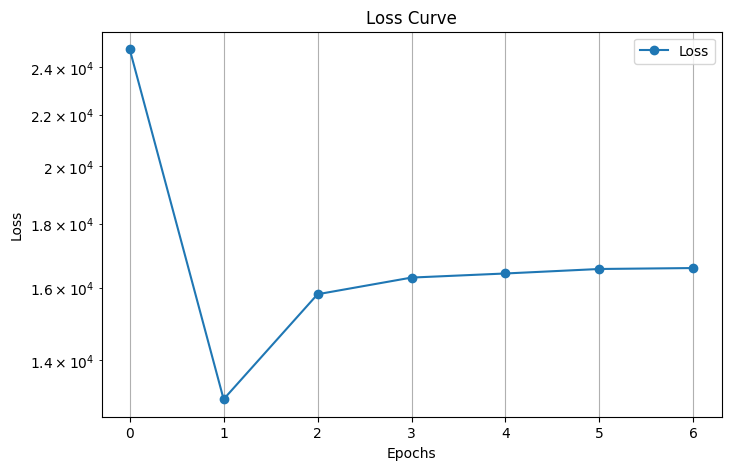

In [14]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(all_loss, marker='o', linestyle='-', label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')  # Use a logarithmic scale for better visualization of large values
plt.grid(True)
plt.legend()
plt.show()

## Step 6: Save and Extract Word Embeddings

In [15]:
import os
import csv

# Step 1: Save embeddings to a CSV file
def save_embeddings_to_csv(model, vocabulary, output_file="skip_word_2_embeddings.csv"):
    # Extract input embeddings from the model
    embeddings = model.input_embedding.weight.data.cpu().numpy()
    
    # Open the CSV file for writing
    with open(output_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        
        # Write the header (optional)
        writer.writerow(["Word"] + [f"Dim{i}" for i in range(embeddings.shape[1])])
        
        # Write each word and its embedding
        for word, idx in vocabulary.items():
            vector = embeddings[idx]
            writer.writerow([word] + vector.tolist())
    
    print(f"Embeddings saved to {output_file}")

# Save the embeddings to a CSV file
save_embeddings_to_csv(model, vocabulary)

Embeddings saved to skip_word_2_embeddings.csv


## Step 7: Visualize Word Embeddings with t-SNE

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 8.1: Extract embeddings
def extract_embeddings(model, vocabulary):
    embeddings = model.input_embedding.weight.data.cpu().numpy()  # Input embeddings
    words = list(vocabulary.keys())
    return embeddings, words

# Extract and visualize
embeddings, words = extract_embeddings(model, vocabulary)

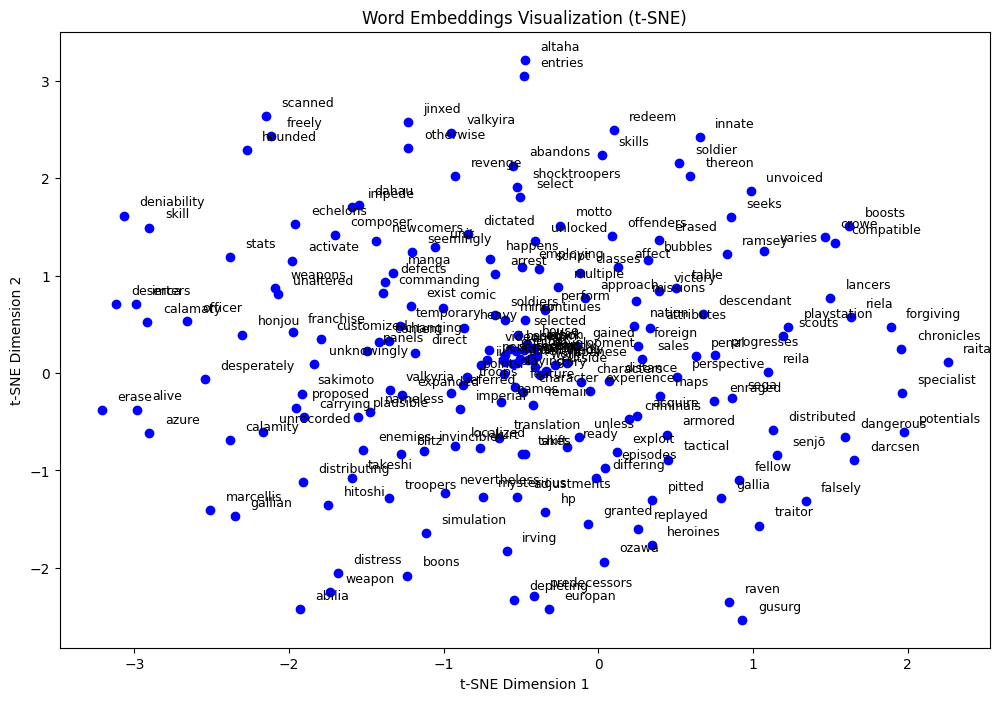

In [17]:
# Step 8.2: Visualize embeddings with t-SNE
def visualize_embeddings(embeddings, words, num_words=200):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings[:num_words])  # Reduce dimensionality

    # Plot the embeddings
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(words[:num_words]):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x + 0.1, y + 0.1, label, fontsize=9)
    plt.title("Word Embeddings Visualization (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

visualize_embeddings(embeddings, words)

## Step 8: Word Similarity Task

In [18]:
import numpy as np

# Step 1: Define a function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Step 2: Find similar words
def find_similar_words(word, vocabulary, embeddings, top_n=5):
    if word not in vocabulary:
        print(f"Word '{word}' not in vocabulary.")
        return []

    word_idx = vocabulary[word]
    word_vec = embeddings[word_idx]
    
    # Compute similarity for all words
    similarities = []
    for other_word, other_idx in vocabulary.items():
        if other_word == word:
            continue
        other_vec = embeddings[other_idx]
        similarity = cosine_similarity(word_vec, other_vec)
        similarities.append((other_word, similarity))
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Test word similarity
word = "king"  # Change to a word in your vocabulary
similar_words = find_similar_words(word, vocabulary, embeddings)
print(f"Words similar to '{word}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word}: {similarity:.4f}")

Words similar to 'king':
councils: 0.2938
cookei: 0.2910
technicality: 0.2793
chloropyta: 0.2722
succeed: 0.2711


## Step 9: Word Analogy Task

In [19]:
# Step 1: Perform word analogy
def word_analogy(word_a, word_b, word_c, vocabulary, embeddings):
    if word_a not in vocabulary or word_b not in vocabulary or word_c not in vocabulary:
        print("One or more words not in vocabulary.")
        return None

    # Get vectors for the three words
    vec_a = embeddings[vocabulary[word_a]]
    vec_b = embeddings[vocabulary[word_b]]
    vec_c = embeddings[vocabulary[word_c]]

    # Compute the analogy vector: vec_d = vec_b - vec_a + vec_c
    analogy_vec = vec_b - vec_a + vec_c

    # Find the closest word to vec_d
    best_word = None
    best_similarity = -float('inf')
    for word, idx in vocabulary.items():
        if word in [word_a, word_b, word_c]:
            continue
        vec = embeddings[idx]
        similarity = cosine_similarity(analogy_vec, vec)
        if similarity > best_similarity:
            best_similarity = similarity
            best_word = word

    return best_word

# Test word analogy
word_a, word_b, word_c = "king", "man", "woman"  # Example analogy
result = word_analogy(word_a, word_b, word_c, vocabulary, embeddings)
print(f"'{word_a}' - '{word_b}' + '{word_c}' ≈ '{result}'")

'king' - 'man' + 'woman' ≈ 'competitive'
